# **NFS 서버 설치**

### NFS 설치

원래는 별도의 NFS 서버를 사용해야하지만, 테스트를 위해 Worker Node2에 NFS Server 를 설치해서 사용.

* Worker Node2에 nfs 설치
```
# apt-get update
# apt install nfs-common nfs-kernel-server portmap
```

* 다른 Worker Node 모두에 nfs-common 설치 <-- 안하면 mount 안됨
```
# apt-get update
# apt install nfs-common
```

### NFS 설정(NFS 서버에서 진행)

* `/etc/exports` 파일에 공유 정보 설정
```
/home/nfs    10.1.11.7(rw,sync,no_subtree_check) 10.1.11.8(rw,sync,no_subtree_check) 10.1.11.9(rw,sync,no_subtree_check)
```

* `nfs-server` 재시작
```
# service nfs-server restart
```

* mount 가능한 서버 조회
```
# showmount -e 127.0.0.1
Export list for 127.0.0.1:
/home/nfs 10.1.11.9,10.1.11.8,10.1.11.7
```

* mount(client 서버에서 진행)
형식: `mount -t nfs {nfs 서버 IP}:{nfs 서버 mount 경로} {client 서버 mount 경로}`
```
# mount -t nfs 10.1.11.9:/home/nfs /mnt
```

* mount test

Volume에 파일을 생성하면
```
# echo 'test' > /home/nfs/test.txt
```

mount 경로에서 확인 가능하다.
```
# cat /mnt/test.txt
test
```

# NFS Volume 연결

[※ 쿠버네티스 Volume 공식 문서](https://kubernetes.io/docs/concepts/storage/volumes/)

### NFS Volume mount Pod 실행

* kubernetes docs 확인

[kubernetes docs] > "volume" 검색 > [nfs] 선택해서 참고

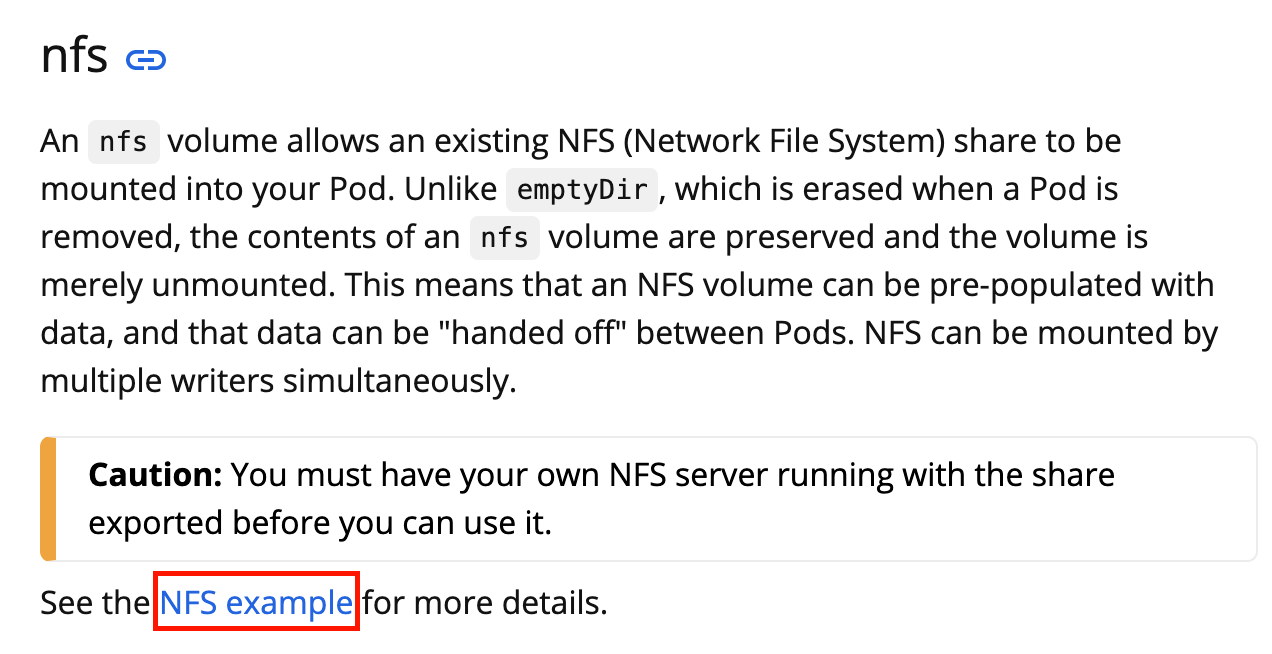

* [NFS example](https://github.com/kubernetes/examples/tree/master/staging/volumes/nfs) 사이트 접속


* 예제 YAML 확인

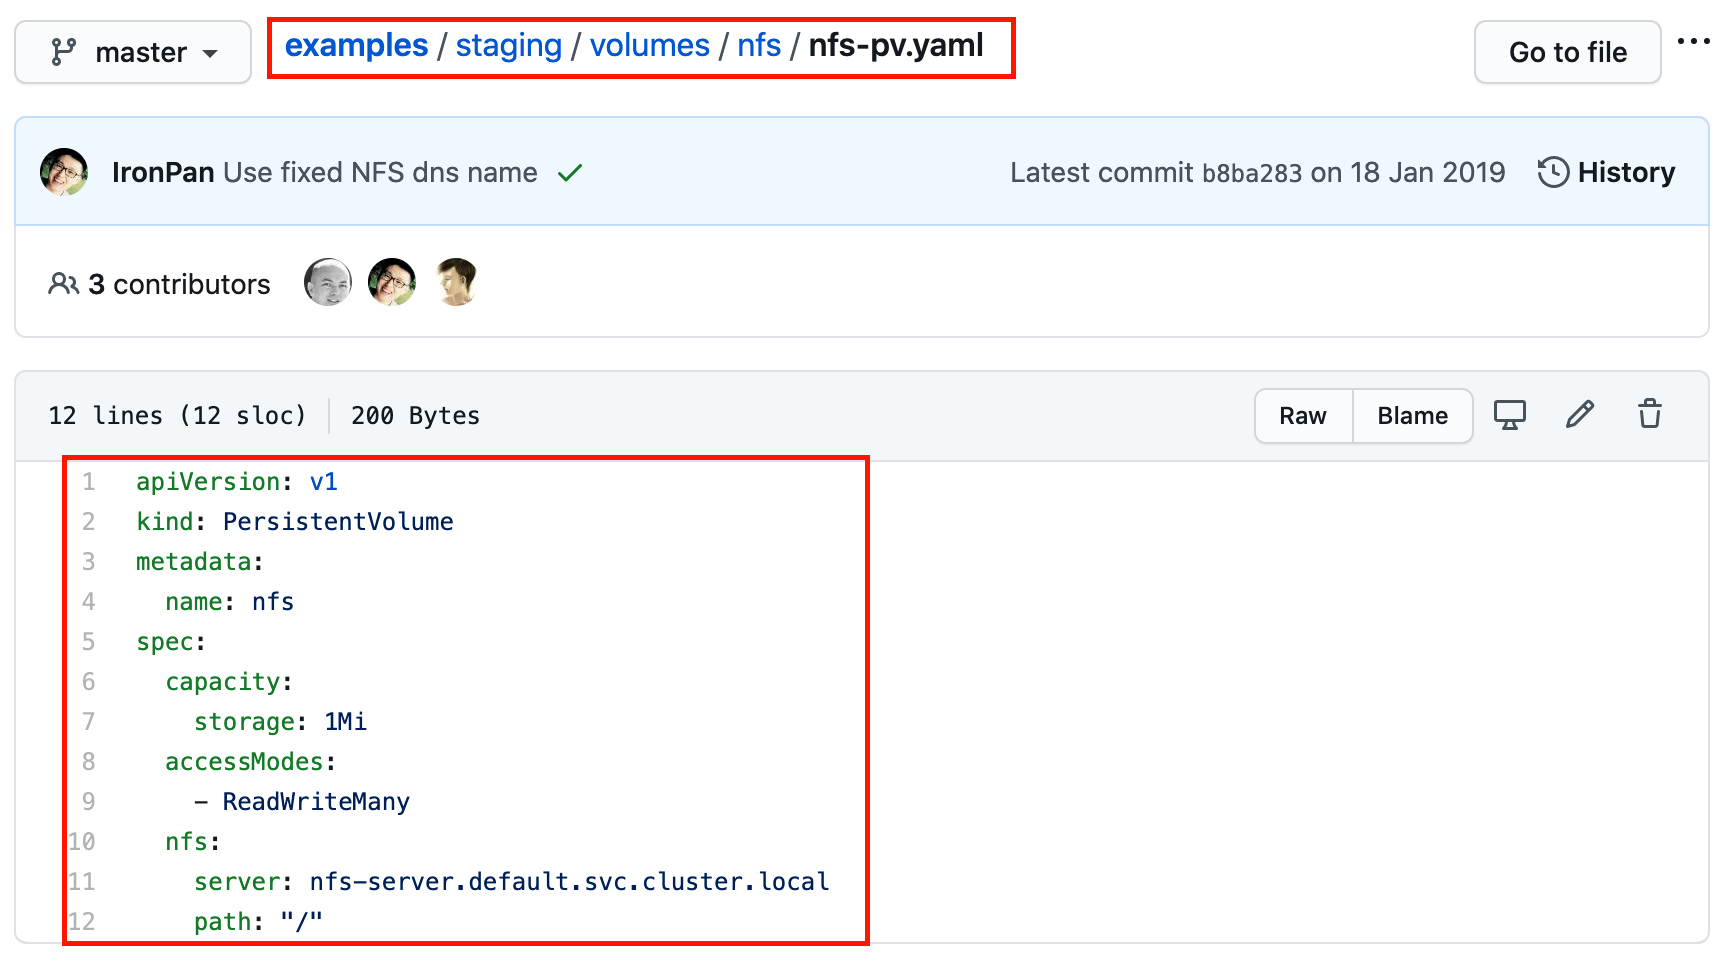

```
apiVersion: v1
kind: PersistentVolume
metadata:
  name: nfs
spec:
  capacity:
    storage: 1Mi
  accessModes:
    - ReadWriteMany
  nfs:
    server: nfs-server.default.svc.cluster.local
    path: "/"
```

* 아래 nfs 설정 부분 복사해서 YAML Volume 설정 부분에 붙여넣을 것
```
  nfs:
    server: nfs-server.default.svc.cluster.local
    path: "/"
```

* nfs volume을 연동하는 YAML 작성

> nfs-httpd.yaml
```
apiVersion: v1
kind: Pod
metadata:
  name: nfs-httpd
spec:
  containers:
  - image: httpd                                <-- httpd 이미지 사용
    name: web
    volumeMounts:
    - mountPath: /usr/local/apache2/htdocs      <-- Container 내부의 정해진 경로
      name: nfs-volume
      readOnly: true                            <-- 읽기 전용
  volumes:
  - name: nfs-volume                            <-- containers array의 volumeMounts.name value와 같아야 함
    nfs:
      server: 10.1.11.9                         <-- nfs 서버
      path: /home/nfs                           <-- nfs 서버 경로
```

* nfs volume을 연동하는 YAML 실행
```
$ kubectl create -f nfs-httpd.yaml
pod/nfs-httpd created
```

* Pod 동작 확인
```
$ kubectl get pod 
NAME                       READY   STATUS              RESTARTS   AGE
nfs-httpd                  1/1     Running             0          5s
```

### NFS Volume mount 테스트

* nfs 서버에 파일 생성
```
$ cd /home/nfs/
$ echo nfs > index.html
$ cat index.html
nfs
```

* `port-forward`로 제대로 동작하는지 확인
```
$ kubectl port-forward nfs-httpd 8888:80
Forwarding from 127.0.0.1:8888 -> 80
Forwarding from [::1]:8888 -> 80

$ curl -i 127.0.0.1:8888
HTTP/1.1 200 OK
Date: Tue, 15 Sep 2020 13:28:02 GMT
Server: Apache/2.4.46 (Unix)
Last-Modified: Tue, 15 Sep 2020 13:01:19 GMT
ETag: "4-5af59bf4b16ae"
Accept-Ranges: bytes
Content-Length: 4
Content-Type: text/html

nfs     <-- Volume mount 정상 동작 확인
```

